Index(['fips', 'fips2024', 'census_region', 'state', 'county', 'cousub',
       'areaname26', 'name', 'msa26', 'fmr26_0',
       ...
       'fmr85_3', 'fmr85_4', 'fmr85', 'msa83', 'fmr83_0', 'fmr83_1', 'fmr83_2',
       'fmr83_3', 'fmr83_4', 'fmr83'],
      dtype='object', length=310)
        fips   fips2024  census_region  state  county  cousub  \
0  100199999  100199999            3.0      1       1   99999   
1  100399999  100399999            3.0      1       3   99999   
2  100599999  100599999            3.0      1       5   99999   
3  100799999  100799999            3.0      1       7   99999   
4  100999999  100999999            3.0      1       9   99999   

                                 areaname26            name             msa26  \
0                        Montgomery, AL MSA  Autauga County  METRO33860M33860   
1             Daphne-Fairhope-Foley, AL MSA  Baldwin County  METRO19300M19300   
2                        Barbour County, AL  Barbour County  NCNTY01005N01005   

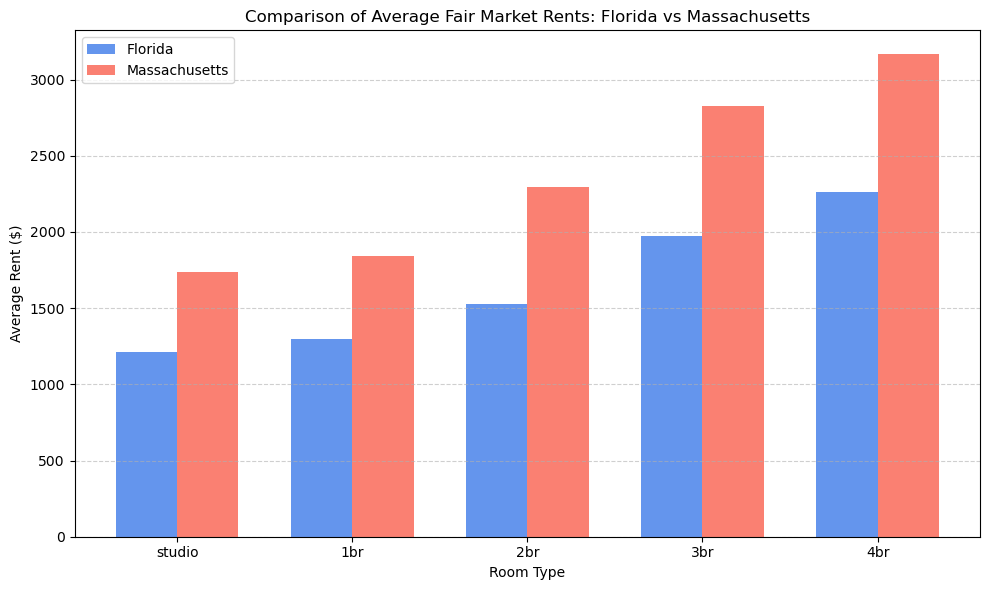

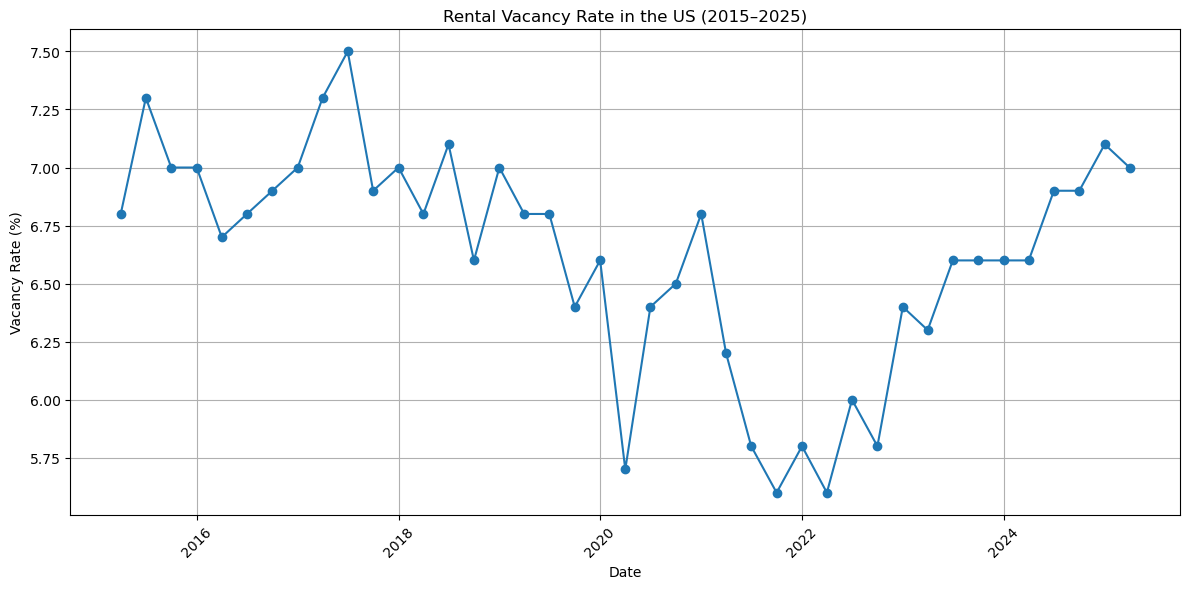

Average annual house price growth rate (2016-2025): 0.0441 or 4.41%
National Average Vacancy Rate (2015-2025): 6.62%
Average annual rental supply growth: 0.0138 or 1.38%
National Average Vacancy Rate (2015-2025): 6.62%
Selected State: New Mexico
Average Rents: {'studio': '$831', '1br': '$930', '2br': '$1,134', '3br': '$1,505', '4br': '$1,772'}
FMR Growth Rate: 4.5%/year
House Price Growth: 3.7%/year
Effective Annual Rent Growth: 4.1%/year
National Vacancy Rate: 6.6%
Rental Supply Growth: 1.4%/year
Unit 0: Room Type = 4br, Rent = $1775
Unit 1: Room Type = 2br, Rent = $1085
Unit 2: Room Type = 4br, Rent = $1549
Unit 3: Room Type = 1br, Rent = $959
Unit 4: Room Type = 3br, Rent = $1462
Unit 5: Room Type = 2br, Rent = $1261
Unit 6: Room Type = 2br, Rent = $948
Unit 7: Room Type = studio, Rent = $836
Unit 8: Room Type = 2br, Rent = $1340
Unit 9: Room Type = 2br, Rent = $1075
Unit 10: Room Type = 3br, Rent = $1685
Unit 11: Room Type = 2br, Rent = $1043
Unit 12: Room Type = studio, Rent = $76

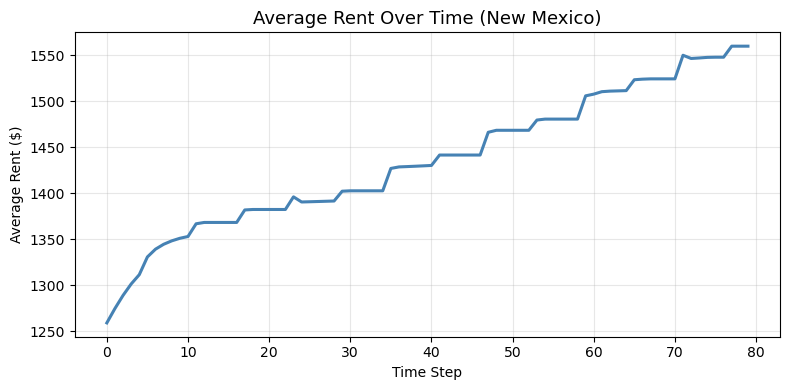

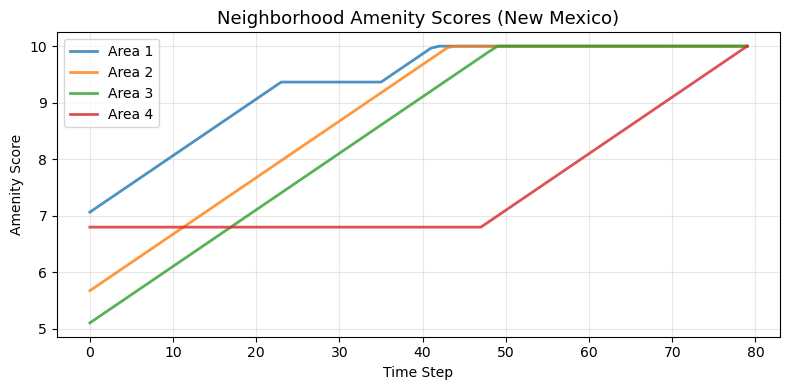

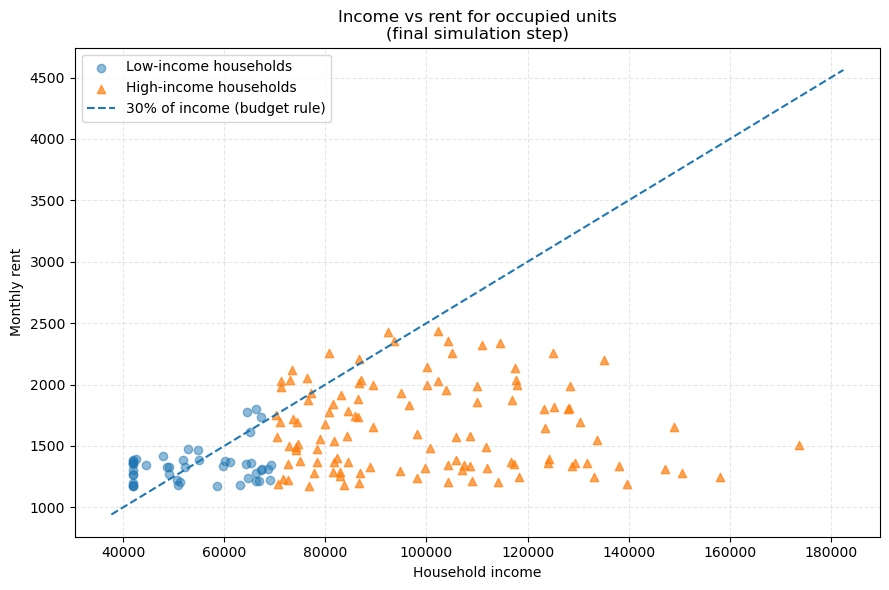

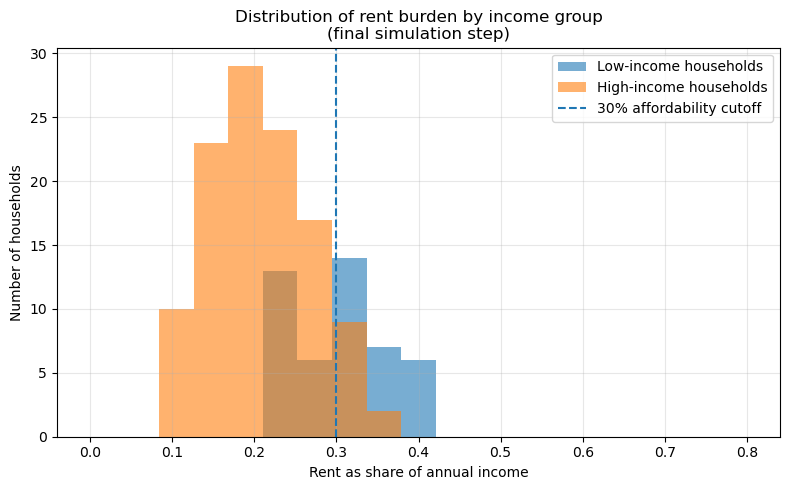

Overall share > 30% of income: 22.5%
Low-income share  > 30%: 56.5%
High-income share > 30%: 8.8%


In [33]:
%run Project3_ABM.ipynb

In [34]:
def run_single_sim(rent_growth_weight: float,
                   n_steps: int = 50,
                   seed: int = 42,
                   
                  ):
    """
    Run one simulation with a given rent_growth_weight and return:
    - model annual rent growth (from avg_rent_history)
    - target FMR annual growth (from sim.growth_rates)
    - absolute error between them
    - accuracy = 1 - |error| / |target|
    """
    # Fix randomness so each weight uses the same state & starting conditions
    random.seed(seed)
    np.random.seed(seed)

    sim = HousingSimulation(
        n_households=100,
        n_neighborhoods=3,
        units_per_neighborhood=40,
        n_steps=n_steps,
        rent_growth_weight=rent_growth_weight,
        
    )
    sim.run()

    # Model annual rent growth based on average rent history
    start_rent = sim.avg_rent_history[0]
    end_rent = sim.avg_rent_history[-1]
    years = n_steps / 12.0  # 12 steps ≈ 1 year

    # Avoid divide-by-zero in weird cases
    if start_rent <= 0:
        model_growth = 0.0
    else:
        model_growth = (end_rent / start_rent) ** (1 / years) - 1

    # Target growth from FMR data (used to initialize the model)
    fmr_growth = float(np.mean(list(sim.growth_rates.values())))

    # Absolute error + "accuracy" score
    abs_error = abs(model_growth - fmr_growth)
    denom = max(abs(fmr_growth), 1e-6)
    accuracy = max(0.0, 1.0 - abs_error / denom)

    return {
        "weight": rent_growth_weight,
        "model_growth": model_growth,
        "fmr_growth": fmr_growth,
        "abs_error": abs_error,
        "accuracy": accuracy,
    }


def calibrate_rent_growth_weight(
    candidate_weights=None,
    n_steps: int = 50,
    seed: int = 42,
):
    """
    Try a list of rent_growth_weight values, pick the one that makes
    model rent growth closest to FMR rent growth, and print an
    'ending accuracy' for each candidate.
    """
    if candidate_weights is None:
        # You can tweak this grid if you want finer calibration
        candidate_weights = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]

    results = []
    for w in candidate_weights:
        res = run_single_sim(w, n_steps=n_steps, seed=seed)
        results.append(res)
        print(
            f"w={res['weight']:.2f} | "
            f"model growth={res['model_growth']:.3%}, "
            f"target={res['fmr_growth']:.3%}, "
            f"error={res['abs_error']:.3%}, "
            f"accuracy={res['accuracy']:.1%}"
        )

    # Choose the weight with the smallest absolute error
    best = min(results, key=lambda r: r["abs_error"])
    print("\nBest calibrated parameter:")
    print(f"  rent_growth_weight = {best['weight']:.2f}")
    print(f"  Ending accuracy     = {best['accuracy']:.1%}")

    return best, results


In [35]:
best_result, calibration_results = calibrate_rent_growth_weight()
best_weight = best_result["weight"]

National Average Vacancy Rate (2015-2025): 6.62%
Selected State: South Dakota
Average Rents: {'studio': '$691', '1br': '$784', '2br': '$990', '3br': '$1,295', '4br': '$1,540'}
FMR Growth Rate: 4.2%/year
House Price Growth: 3.7%/year
Effective Annual Rent Growth: 3.7%/year
National Vacancy Rate: 6.6%
Rental Supply Growth: 1.4%/year
Unit 0: Room Type = 1br, Rent = $774
Unit 1: Room Type = studio, Rent = $588
Unit 2: Room Type = studio, Rent = $739
Unit 3: Room Type = studio, Rent = $700
Unit 4: Room Type = 4br, Rent = $1393
Unit 5: Room Type = studio, Rent = $728
Unit 6: Room Type = 1br, Rent = $761
Unit 7: Room Type = 2br, Rent = $904
Unit 8: Room Type = 3br, Rent = $1502
Unit 9: Room Type = studio, Rent = $768
Unit 10: Room Type = 4br, Rent = $1786
Unit 11: Room Type = 2br, Rent = $1148
Unit 12: Room Type = 4br, Rent = $1649
Unit 13: Room Type = studio, Rent = $648
Unit 14: Room Type = 1br, Rent = $817
Unit 15: Room Type = studio, Rent = $500
Unit 16: Room Type = 3br, Rent = $1214
Unit


Running calibrated simulation with rent_growth_weight = 0.00
National Average Vacancy Rate (2015-2025): 6.62%
Selected State: Michigan
Average Rents: {'studio': '$807', '1br': '$891', '2br': '$1,113', '3br': '$1,419', '4br': '$1,588'}
FMR Growth Rate: 4.6%/year
House Price Growth: 3.7%/year
Effective Annual Rent Growth: 3.7%/year
National Vacancy Rate: 6.6%
Rental Supply Growth: 1.4%/year
Unit 0: Room Type = 2br, Rent = $1138
Unit 1: Room Type = 1br, Rent = $911
Unit 2: Room Type = 4br, Rent = $1685
Unit 3: Room Type = 2br, Rent = $988
Unit 4: Room Type = 3br, Rent = $1432
Unit 5: Room Type = 2br, Rent = $1179
Unit 6: Room Type = 1br, Rent = $898
Unit 7: Room Type = studio, Rent = $859
Unit 8: Room Type = studio, Rent = $893
Unit 9: Room Type = studio, Rent = $840
Unit 10: Room Type = 1br, Rent = $871
Unit 11: Room Type = studio, Rent = $847
Unit 12: Room Type = 3br, Rent = $1397
Unit 13: Room Type = 2br, Rent = $1156
Unit 14: Room Type = studio, Rent = $956
Unit 15: Room Type = 4br, 

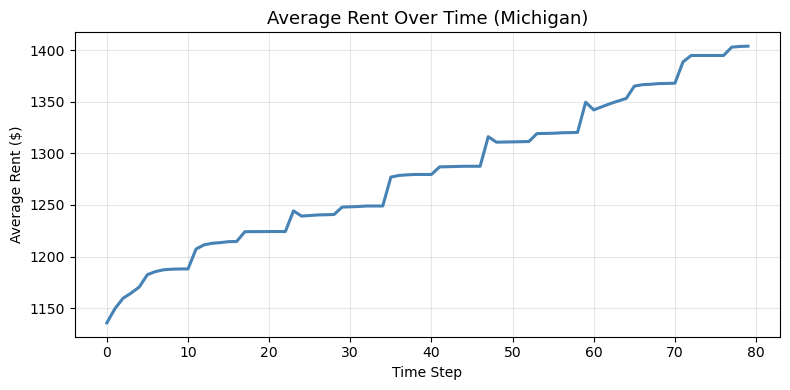

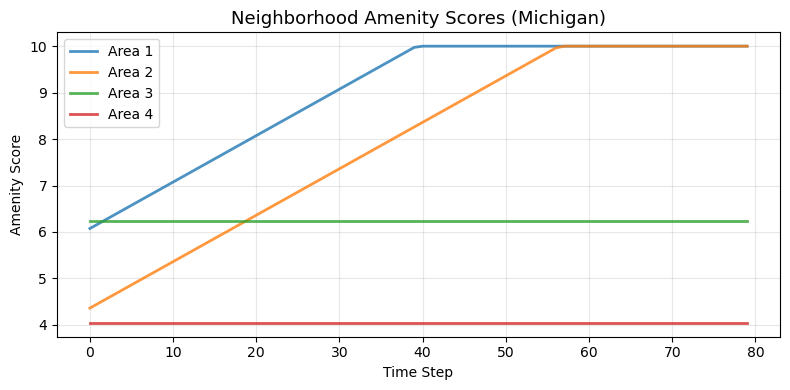

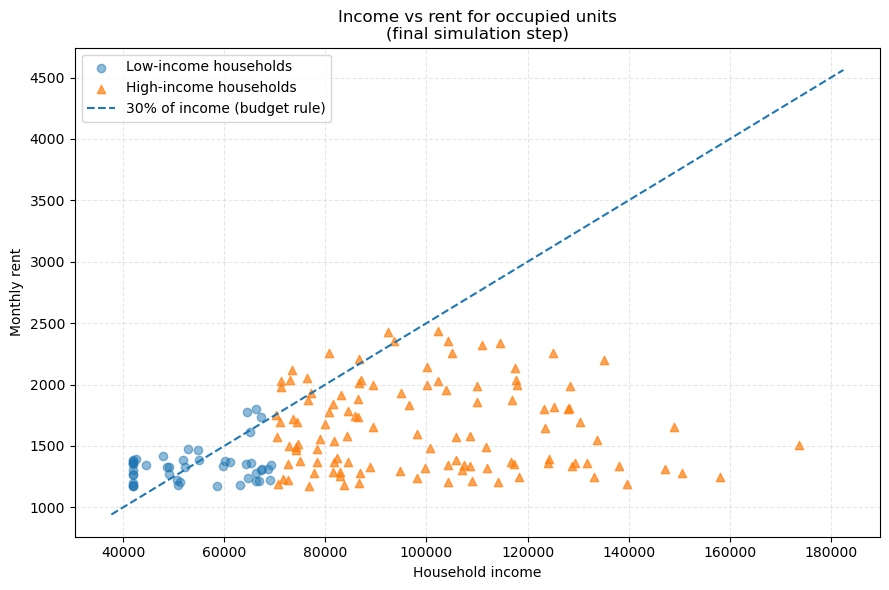

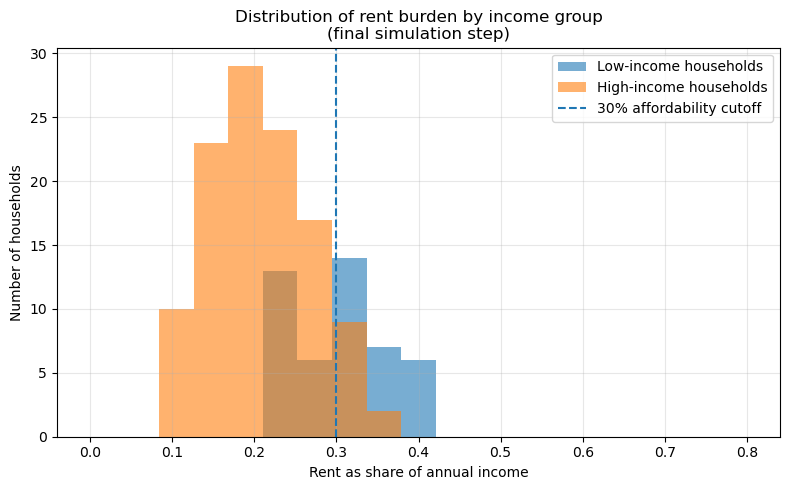

Overall share > 30% of income: 22.5%
Low-income share  > 30%: 56.5%
High-income share > 30%: 8.8%


In [40]:
# Calibrated run using best_weight

# best_weight was returned by calibrate_rent_growth_weight above
print(f"\nRunning calibrated simulation with rent_growth_weight = {best_weight:.2f}")

sim_calibrated = HousingSimulation(
    n_households=160,
    n_neighborhoods=4,
    units_per_neighborhood=40,
    n_steps=80,
    rent_growth_weight=best_weight,
)

sim_calibrated.run()

# Quick summary of how well the calibrated run matches the data
start_rent = sim_calibrated.avg_rent_history[0]
end_rent = sim_calibrated.avg_rent_history[-1]
years = sim_calibrated.n_steps / 12.0
model_growth_cal = (end_rent / start_rent) ** (1 / years) - 1
fmr_growth_cal = float(np.mean(list(sim_calibrated.growth_rates.values())))

print(f"Calibrated run state:          {sim_calibrated.state_name}")
print(f"Target FMR rent growth:        {fmr_growth_cal:.2%}/year")
print(f"Model average rent growth:     {model_growth_cal:.2%}/year")
print(f"Absolute error (calibrated):   {abs(model_growth_cal - fmr_growth_cal):.2%}")
print(f"Accuracy:                      {best_result['accuracy']:.1%}")

sim_calibrated.visualize()